# Traditional Machine Learning Forecasting Methods

The previous notebooks covered traditional statistical methods, each having its own pros and cons.
The next step is to try traditional machine learning methods.

Machine learning methods allow for a variety of models to be used for forecasting. In particular, they allow for complex non-linear relationships to be modeed. Also, ML models allow for different forecasting horizons, such as 1-step, multi-step, and multi-output. We can also do ML forecasting for the actual signal as well as the differenced one (typically needed for signals that have a trend)

Below we go over a number of machine learning models and how to use them for forecasting. One major part in this exercise is the data processing part required to create the datasets for each of the three types of forecasting

In [535]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error

import statsmodels.api as sm
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

In [536]:
df=pd.read_excel('Traffic.xlsx')

df['Start Time'] = pd.to_datetime(df['Start Time'])
df.set_index('Start Time',drop=False,inplace=True)
df['DL RBLER (%)']=df['DL RBLER (%)'].replace('NIL',np.nan)
df['DL RBLER (%)']=df['DL RBLER (%)'].astype(float)
df['DL RBLER (%)'].fillna(df['DL RBLER (%)'].median(),inplace=True)
df['DL user tput']=df['L.Thrp.bits.DL.QCI.9 (bit)']/(df['L.Thrp.Time.DL.QCI.9 (ms)']*1000)
df['DL cell tput']=df['L.Thrp.bits.DL (bit)']/(df['L.Thrp.Time.Cell.DL (s)']*1000000)

df['DL user tput']=df['DL user tput'].replace(np.nan,0)
df['DL cell tput']=df['DL cell tput'].replace(np.nan,0)

df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3401-2']

df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
df_filter.index

DatetimeIndex(['2013-08-28 00:00:00', '2013-08-28 00:15:00',
               '2013-08-28 00:30:00', '2013-08-28 00:45:00',
               '2013-08-28 01:00:00', '2013-08-28 01:15:00',
               '2013-08-28 01:30:00', '2013-08-28 01:45:00',
               '2013-08-28 02:00:00', '2013-08-28 02:15:00',
               ...
               '2013-09-04 21:30:00', '2013-09-04 21:45:00',
               '2013-09-04 22:00:00', '2013-09-04 22:15:00',
               '2013-09-04 22:30:00', '2013-09-04 22:45:00',
               '2013-09-04 23:00:00', '2013-09-04 23:15:00',
               '2013-09-04 23:30:00', '2013-09-04 23:45:00'],
              dtype='datetime64[ns]', name='Start Time', length=768, freq='15T')

Up to here is similar to what we did for ARIMA and ETS methods.

Now, we will add a differenced data column to our dataset. We will use it when we get to forecasting with differencing

In [213]:
df_filter['1st_diff_tput']=df_filter['DL user tput'].diff()

We then create a train and test sets. The test set is one full day as before (96 samples)

In [517]:
Samtest=196
train=df_filter.iloc[:-Samtest]
test=df_filter.iloc[-Samtest:]


#train_idx=df_filter.index <= train.index[-1]
#test_idx=df_filter.index > train.index[-1]

Next we create the dataset for the 1-step forecasting. 1-step forecasting is usefull when we need to get forecasts one step ahead only. In our data that corresponds to knowing the DL user tput 15 minutes ahead. This could be useful in cases where the content will be customised based on the users download speed

In [544]:

#Put the user tput column in a numpy array. Not really required but working with numpy arrays is usually easier

series=df_filter['DL user tput'].to_numpy()

#T is size of our inputs, which in our case is the previous 96 data points.
#X and Y are empty lists and are placeholders for our input and output

T=96
X=[]
Y=[]

# Run a for loop where you store each set of 96 inputs in X and the next datapoint as the output in Y. Each time we
#append the X and Y lists

for t in range(len(series)-T):
    x=series[t:t+T]
    X.append(x)
    y=series[t+T]
    Y.append(y)

#put back X and Y into arrays and reshape X as T inputs
X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)

#create new train and test sets based on our reshaped datasets X and Y. Samtest is used as our cutoff between train and test
Xtrain, Ytrain=X[:-Samtest], Y[:-Samtest]
Xtest, Ytest=X[-Samtest:], Y[-Samtest:]


#Create and index for train and test from the original dataframe.
#Make sure to remove the first 96 datapoints from the train set as they are only used as part of the input data

train_idx=df_filter.index <= train.index[-1]
test_idx=~train_idx
train_idx[:T]=False

#Train the ML model...Linear Regression is used as an example

lr=LinearRegression()
lr.fit(Xtrain,Ytrain)

#generate 1-step predictions for both train and test data and store the output back in the original dataframe based on
# the train and test indicies
df_filter.loc[train_idx,'LR_1step_train']=lr.predict(Xtrain)
df_filter.loc[test_idx,'LR_1step_test']=lr.predict(Xtest)


#Multi-step predictions: Create an empty list as a placeholder for the multi-step results
#Set the first datapoint in test as the last known sample
#generate predictions by using a while loop (as long as the muilt-step results list is 
#less than the Samtest forecast horizon) and append every output to the list
#Update the last known sample by setting it to the predicted value and repeat up to Samtest times


multistep_predictions=[]

last_x=Xtest[0]

while len(multistep_predictions) < Samtest:
    p=lr.predict(last_x.reshape(1,-1))[0]
    
    multistep_predictions.append(p)
    
    last_x=np.roll(last_x,-1)
    last_x[-1]=p
    
#Update the original dataframe
df_filter.loc[test_idx,'LR_multistep']=multistep_predictions


In [474]:
Ytrain.shape

(576,)

In [520]:
lr=LinearRegression()
lr.fit(Xtrain,Ytrain)
lr.score(Xtrain,Ytrain)

0.8513844843895675

In [521]:
lr.score(Xtest,Ytest)

0.7586190083157711

In [522]:
train_idx=df_filter.index <= train.index[-1]
test_idx=~train_idx

#train_idx[:T+1]=False
train_idx[:T]=False

In [523]:
df_filter.loc[train_idx,'LR_1step_train']=lr.predict(Xtrain)
df_filter.loc[test_idx,'LR_1step_test']=lr.predict(Xtest)

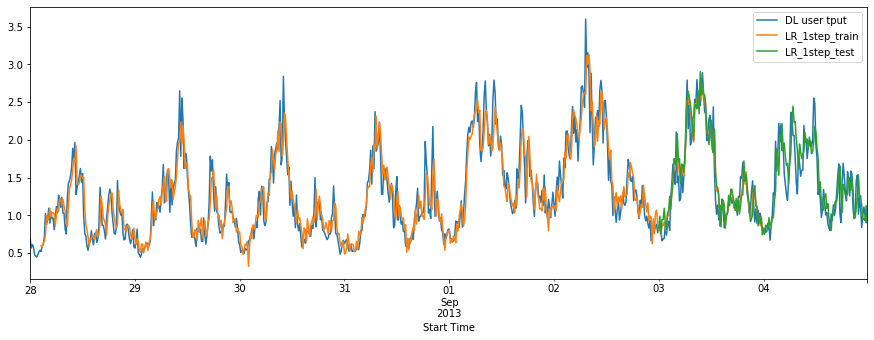

In [524]:
df_filter[['DL user tput','LR_1step_train','LR_1step_test']].plot(figsize=(15,5))

In [525]:
multistep_predictions=[]

last_x=Xtest[0]

while len(multistep_predictions) < Samtest:
    p=lr.predict(last_x.reshape(1,-1))[0]
    
    multistep_predictions.append(p)
    
    last_x=np.roll(last_x,-1)
    last_x[-1]=p
    

In [526]:
df_filter.loc[test_idx,'LR_multistep']=multistep_predictions

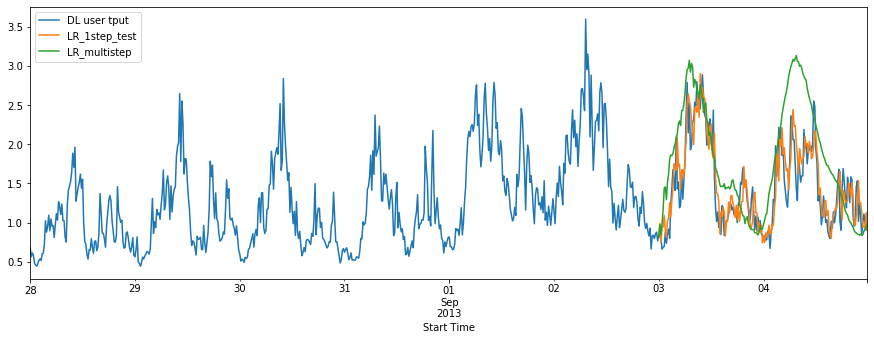

In [527]:
df_filter[['DL user tput','LR_1step_test','LR_multistep']].plot(figsize=(15,5))

In [528]:
Tx=T
Ty=Samtest
X=[]
Y=[]

for t in range(len(series)-Tx-Ty+1):
    x=series[t:t+Tx]
    X.append(x)
    y=series[t+Tx:t+Tx+Ty]
    Y.append(y)
    
X=np.array(X).reshape(-1,Tx)
Y=np.array(Y).reshape(-1,Ty)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (481, 96) Y.shape (481, 192)


In [529]:
Xtrain_m,Ytrain_m=X[:-1],Y[:-1]
Xtest_m,Ytest_m=X[-1:],Y[-1:]

In [530]:
lr=LinearRegression()
lr.fit(Xtrain_m,Ytrain_m)
lr.score(Xtrain_m,Ytrain_m)


0.5683169428982854

In [418]:
lr.score(Xtest_m,Ytest_m)

nan

In [531]:
r2_score(lr.predict(Xtest_m).flatten(),Ytest_m.flatten())

0.3027754961143505

In [532]:
#df_filter.loc[test_idx,'LR_multioutput']=last_train+np.cumsum(lr.predict(Xtest_m).flatten())
df_filter.loc[test_idx,'LR_multioutput']=lr.predict(Xtest_m).flatten()

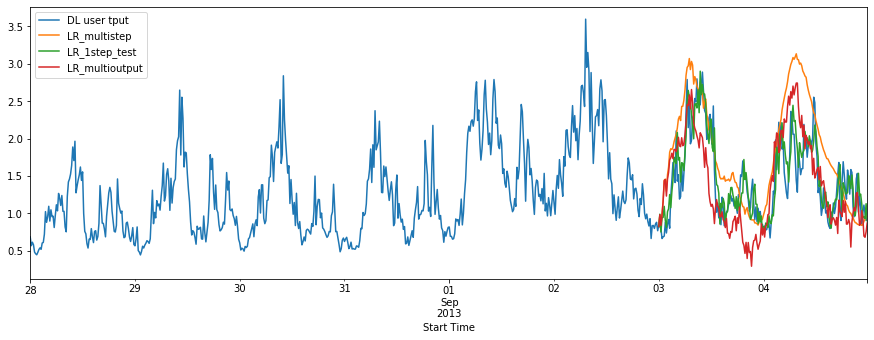

In [533]:
cols=['DL user tput','LR_multistep','LR_1step_test','LR_multioutput']
df_filter[cols].plot(figsize=(15,5))

In [534]:
test_tput=df_filter.iloc[-Samtest:]['DL user tput']

#RMSE1=np.sqrt(mean_squared_error(test_tput,df_filter.loc[test_idx,'LR_multistep']))
RMSE1=np.sqrt(mean_squared_error(Ytest,multistep_predictions))

print("multistep_predictions RMSE:",RMSE1)

#RMSE2=np.sqrt(mean_squared_error(test_tput,df_filter.loc[test_idx,'LR_multioutput']))
RMSE2=np.sqrt(mean_squared_error(Ytest,df_filter.loc[test_idx,'LR_multioutput']))

print("multioutput RMSE:",RMSE2)

multistep_predictions RMSE: 0.6159929892995639
multioutput RMSE: 0.5195711106493354


### Create framework for testing different models

In [369]:
def one_step_multistep_forecast(model,name):
    
    model.fit(Xtrain,Ytrain)
    print("One-step forecast:",name)
    
    df_filter.loc[train_idx,f'{name}_1step_train']=model.predict(Xtrain)
    df_filter.loc[test_idx,f'{name}_1step_test']=model.predict(Xtest)
    
    multistep_predictions=[]
    
    last_x=Xtest[0]
    
    while len(multistep_predictions) < Samtest:
        p=model.predict(last_x.reshape(1,-1))[0]
        
        multistep_predictions.append(p)
        
        last_x=np.roll(last_x,-1)
        last_x[-1]=p
        
    df_filter.loc[test_idx,f'{name}_multistep_test']=multistep_predictions
    
    rmse=np.sqrt(mean_squared_error(Ytest,multistep_predictions))
    
    print("RMSE multi-step:",rmse)
    
    cols=[
        'DL user tput',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test'    
    ]
    df_filter[cols].plot(figsize=(15,5));
    
    
    

One-step forecast: RF
RMSE multi-step: 0.6075486849589117


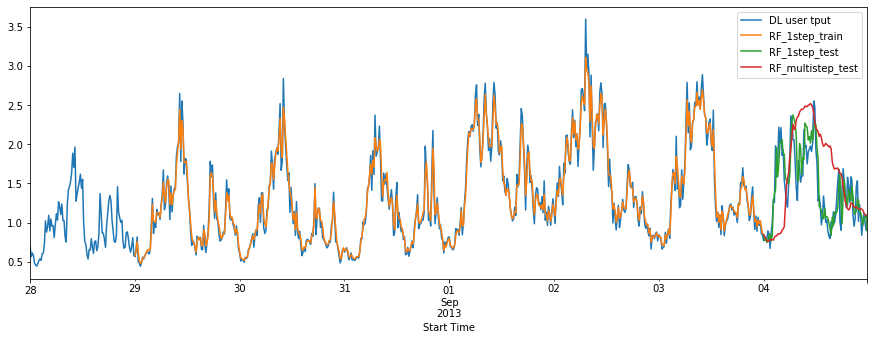

In [432]:
one_step_multistep_forecast(RandomForestRegressor(),"RF")

In [374]:
def multi_output_forecast(model,name):
    model.fit(Xtrain_m,Ytrain_m)
    
    df_filter.loc[test_idx,f'{name}_multioutput']=model.predict(Xtest_m).flatten()
    
    rmse=np.sqrt(mean_squared_error(Ytest,df_filter.loc[test_idx,f'{name}_multioutput']))
    print("Test RMSE multioutput:",rmse)
    
    cols=[
        'DL user tput',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test',
        f'{name}_multioutput'
    ]
    df_filter[cols].plot(figsize=(15,5));
    

Test RMSE multioutput: 0.31433796232323447


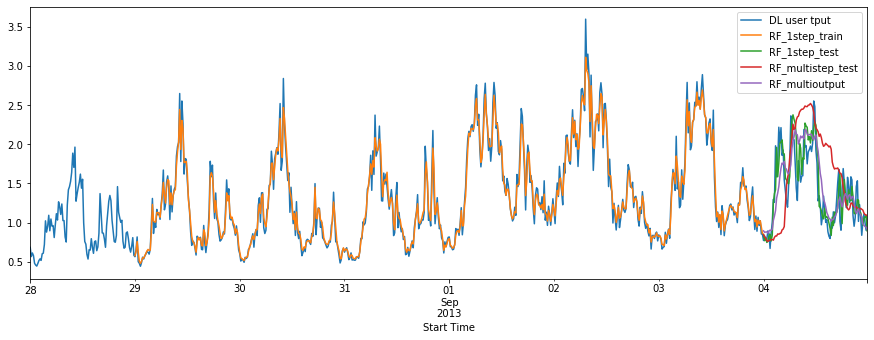

In [439]:
multi_output_forecast(RandomForestRegressor(),"RF")

### Machine Learning Forecasting with Differencing

In [388]:
df_filter['1st_diff_tput']=df_filter['DL user tput'].diff()


Samtest=96
train=df_filter.iloc[:-Samtest]
test=df_filter.iloc[-Samtest:]

series=df_filter['1st_diff_tput'].to_numpy()[1:]


T=96
X=[]
Y=[]

for t in range(len(series)-T):
    x=series[t:t+T]
    X.append(x)
    y=series[t+T]
    Y.append(y)
    
X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

Xtrain, Ytrain=X[:-Samtest], Y[:-Samtest]
Xtest, Ytest=X[-Samtest:], Y[-Samtest:]

train_idx=df_filter.index <= train.index[-1]
test_idx=~train_idx

train_idx[:T+1]=False

df_filter['Shift_tput']=df_filter['DL user tput'].shift(1)
prev=df_filter['Shift_tput']

last_train=train.iloc[-1]['DL user tput']

Tx=T
Ty=Samtest
X=[]
Y=[]

for t in range(len(series)-Tx-Ty+1):
    x=series[t:t+Tx]
    X.append(x)
    y=series[t+Tx:t+Tx+Ty]
    Y.append(y)
    
X=np.array(X).reshape(-1,Tx)
Y=np.array(Y).reshape(-1,Ty)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

Xtrain_m,Ytrain_m=X[:-1],Y[:-1]
Xtest_m,Ytest_m=X[-1:],Y[-1:]


X.shape (671, 96) Y.shape (671,)
X.shape (576, 96) Y.shape (576, 96)


In [378]:
def one_step_multistep_forecast_diff(model,name):
    
    model.fit(Xtrain,Ytrain)
    print("One-step forecast:",name)
    
    df_filter.loc[train_idx,f'{name}_1step_train']=prev[train_idx]+model.predict(Xtrain)
    df_filter.loc[test_idx,f'{name}_1step_test']=prev[test_idx]+model.predict(Xtest)
    
    multistep_predictions=[]
    
    last_x=Xtest[0]
    
    while len(multistep_predictions) < Samtest:
        p=model.predict(last_x.reshape(1,-1))[0]
        
        multistep_predictions.append(p)
        
        last_x=np.roll(last_x,-1)
        last_x[-1]=p
        
    df_filter.loc[test_idx,f'{name}_multistep_test']=last_train+np.cumsum(multistep_predictions)
    
    rmse=np.sqrt(mean_squared_error(test_tput,df_filter.loc[test_idx,f'{name}_multistep_test']))
    
    print("RMSE multi-step:",rmse)
    
    cols=[
        'DL user tput',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test'    
    ]
    df_filter[cols].plot(figsize=(15,5));
    
    
  


    

In [379]:
def multi_output_forecast_diff(model,name):
    model.fit(Xtrain_m,Ytrain_m)
    
    df_filter.loc[test_idx,f'{name}_multioutput']= \
    last_train+np.cumsum(model.predict(Xtest_m).flatten())
    
    rmse=np.sqrt(mean_squared_error(test_tput,df_filter.loc[test_idx,f'{name}_multioutput']))
    print("Test RMSE multioutput:",rmse)
    
    cols=[
        'DL user tput',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test',
        f'{name}_multioutput'
    ]
    df_filter[cols].plot(figsize=(15,5));

One-step forecast: RF
RMSE multi-step: 0.8119302333813744


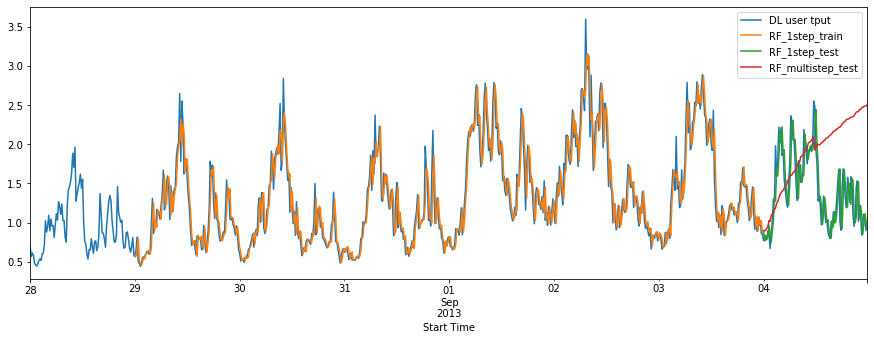

In [402]:
one_step_multistep_forecast_diff(RandomForestRegressor(max_depth=4),"RF")

Test RMSE multioutput: 0.5625272095426316


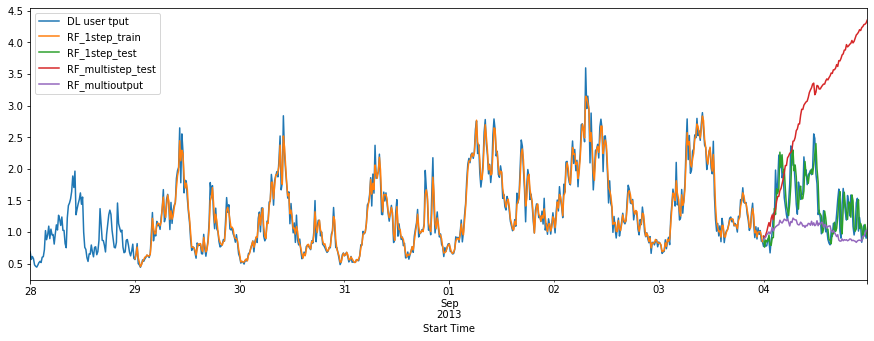

In [391]:
multi_output_forecast_diff(RandomForestRegressor(),"RF")